In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn
from modules.dataset import *
from modules.network import *
from modules.embeddings import *
from modules.generate_text import *
from torch import save, device, cuda
from torch.utils.data import DataLoader

In [2]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cpu


In [3]:
# Set local paths
images_path = "./images"
res_path = "./data/losses"

# Dataset

## Loading and preprocessing

In [4]:
#%%Loading the dataset 

min_len = 12
dataset = Mobydick('./data/mobydick.txt', min_len = min_len)

with open('./data/clean_text', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    
len(dataset)

434

In [5]:
# Given a min_len>2, it is not necessary to delete the chapters titles
print(dataset[0])

['some', 'years', 'ago', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'i', 'thought', 'i', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.']


Mean sentence length: 31.921658986175114
Max sentence length: 127
Min sentence length: 12


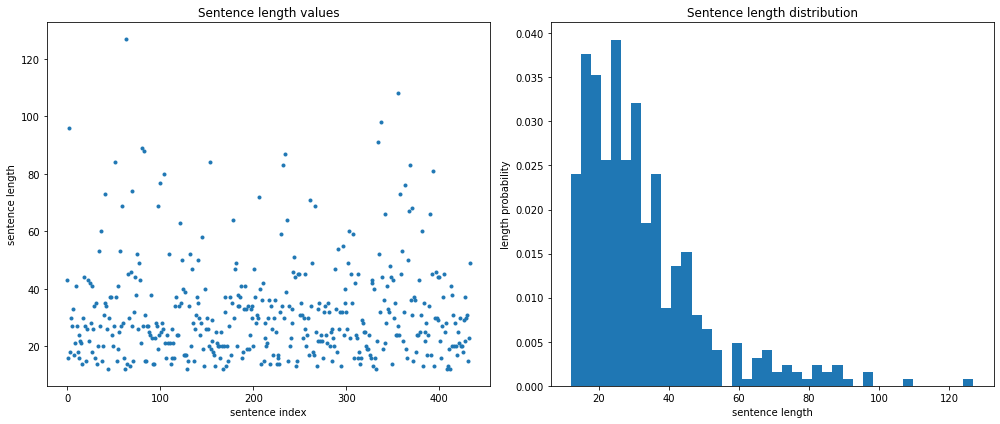

In [6]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

plt.tight_layout()
plt.savefig(images_path+f'/md_{min_len}.png')
plt.show()

In [7]:
print(len(dataset.words))

2944


## Word embeddings

In [8]:
# Define the embedding dimension
embedding_dim = 50

# Copy dataset words
words = set(dataset.words.copy())

In [9]:
# Load embeddings
with open('./data/embeddings', 'rb') as f:
    embeddings = pickle.load(f)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [10]:
crop_len = 10

# Define transformation 
dataset.transform = transforms.Compose([
    RandomCrop(crop_len),
    WordToIndex(words),
    ToTensor()
])

In [11]:
# Defined the transform, this call returns the word index (after random cropping)
dataset[0].shape

torch.Size([10])

# RNN

In [12]:
classification = True

params = {
        # network
        'hidden_units' : 2**9, # symmetric layers
        'layers_num' : 2,
        'dropout_prob' : 0.3,
        'architecture' : 'GRU',

        # training
        'batch_size' : 10,
        'num_epochs' : 100,

        # optimizer
        'lr' : 1e-3,
        'wd' : 5e-5,
    
        # dataset
        'crop_len' : crop_len,
        'min_len' : min_len
        }

# save
out_dir = '{}_{}_{}_{}_{}_{}'.format(params['architecture'], 
                                     params['crop_len'], 
                                     params['min_len'], 
                                     params['batch_size'], 
                                     params['lr'], 
                                     params['wd'])

In [13]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, shuffle=False)

In [14]:
#TODO: hyperparameter optimization, this part must be included in the GridSearch iteration

#%% Initialize network
net = Network(vocab_size = vectors.shape[0],
              embedding_dim = embedding_dim,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = params['architecture'],
              trained_embeddings = vectors,
              freeze_embeddings = False,
              dropout_prob = params['dropout_prob']
             )

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params['wd'])
# Define loss function
loss_fn = nn.MSELoss()
cl = ''
if classification == True:
    loss_fn = nn.CrossEntropyLoss()
    cl = '_class'

net.to(device)

Network(
  (rnn): GRU(50, 512, num_layers=2, batch_first=True, dropout=0.3)
  (out): Linear(in_features=512, out_features=2944, bias=True)
  (embed): Embedding(2944, 50)
)

In [ ]:
%%time

# Initialize WordToVector
w2i = WordToIndex(words)

# Define losses containers
train_loss_epochs = []
val_loss_epochs = []

#%% Train network
for epoch in range(params['num_epochs']):
    print('\n\n EPOCH %d/%d' % (epoch + 1, params['num_epochs']))
    
    # Set training mode
    net.train()
    # Define losses container for one epoch
    train_loss_log = []    
    # Iterate batches
    for batch_sample in train_dataloader:
        # Extract batch
        batch = batch_sample.long().to(device)
        # Update network
        batch_loss = net.train_batch(batch, loss_fn, optimizer)
        train_loss_log.append(batch_loss)
        
    print('\t Training loss (epoch - mean): ', np.mean(train_loss_log) )
    train_loss_epochs.append(np.mean(train_loss_log))
    
    # Set evaluation mode
    net.eval()
    val_loss_log = []
    # Iterate batches
    with torch.no_grad():
        for batch_sample in test_dataloader:
            # Extract batch
            batch = batch_sample.long().to(device)
            # Update network
            val_loss = net.test_batch(batch, loss_fn)
            val_loss_log.append(val_loss)
            
        print('\t Validation loss (epoch - mean):', np.mean(val_loss_log))
        val_loss_epochs.append(np.mean(val_loss_log))
        
        if epoch%10 == 0:
            if not classification:
                # Embedding matrix - updated
                X = net.embed.weight.detach().numpy()
            # Set seed
            seed = 'I want you to know that'
            # Generate sample text
            print('\n\nSample text:\n')
            _ = generate_text(net, seed, 5, device, words, w2i)
            
    # Early stopping
    # if epoch>200 and abs(val_loss_epochs[-1] - val_loss_epochs[-200]) < 1e-10:
    #    break
    
losses = { 'train': train_loss_epochs, 'val':  val_loss_epochs, 'params' : params }

# Save losses dictionary
with open(res_path + "/" + out_dir, 'wb') as f:
    pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)
    
# Save model 
torch.save(net.state_dict(), res_path + "/state_" + out_dir + cl + '.pth')



 EPOCH 1/100
	 Training loss (epoch - mean):  7.075768387317657
	 Validation loss (epoch - mean): 6.503434081410253
I want you to know that the the the the the 

 EPOCH 2/100
	 Training loss (epoch - mean):  6.560609173774719
	 Validation loss (epoch - mean): 6.771389745002569


 EPOCH 3/100
	 Training loss (epoch - mean):  6.499650514125824
	 Validation loss (epoch - mean): 6.619697421096092


 EPOCH 4/100
	 Training loss (epoch - mean):  6.3799618005752565
	 Validation loss (epoch - mean): 7.19299056918122


 EPOCH 5/100
	 Training loss (epoch - mean):  6.709995067119598
	 Validation loss (epoch - mean): 7.789236573285835


 EPOCH 6/100
	 Training loss (epoch - mean):  6.389332902431488
	 Validation loss (epoch - mean): 7.088695027107416


 EPOCH 7/100
	 Training loss (epoch - mean):  6.111063361167908
	 Validation loss (epoch - mean): 6.851114932880845


 EPOCH 8/100
	 Training loss (epoch - mean):  6.248906767368316
	 Validation loss (epoch - mean): 6.567051721173663


 EPOCH 9/1

In [ ]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_epochs, label='Train loss')
plt.semilogy(val_loss_epochs, label='Validation loss', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(images_path + "/model_losses_"  + out_dir + cl + ".png")
plt.show()

# Text generation

In [ ]:
# Set seed
seed = 'When you are alone in the middle of the sea'

In [ ]:
# Load embeddings
with open('./data/embeddings', 'rb') as f:
    embeddings = pickle.load(f)
# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

# Load hyperparameters
with open(res_path + "/" + out_dir, 'rb') as f:
    params = pickle.load(f)
    params = params['params']
    
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model
state = torch.load(res_path + "/state_" + out_dir + cl + '.pth', map_location = device)

net = Network(vocab_size = len(embeddings.keys()),
              embedding_dim = 50,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = params['architecture'],
              trained_embeddings = vectors,
              dropout_prob = params['dropout_prob']
             )

net.load_state_dict(state)

# Embedding matrix - updated
X = net.embed.weight.detach().numpy()

net.to(device)

In [ ]:
# Initialize WordToVector
w2i = WordToIndex(words)

In [ ]:
_ = generate_text(net, seed, 15, device, words, w2i)